In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import os,binascii
import datetime
import matplotlib
import plotly.graph_objects as go
import random
plt.rcParams["figure.figsize"] = (20,10)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [2]:
# model = 'brent_s&p'
# model = 'us_stock'
model = 'brent'

max_window_start_date = -120
max_window_end_date = -11
threshold = 0.95

window_start_date = -50
window_end_date = -11
opec_day_price_window_start = -10
opec_day_price_window_end = -5
days_before_to_show_return = -10
days_after_to_show_return = 11


name_of_directory = 'brent_results'
if not os.path.isdir(name_of_directory):
    os.makedirs(name_of_directory)

In [3]:
def get_opec_data():
    opec_meetings = pd.read_excel('OPEC_Annuncement_Effect.xlsx', sheet_name = 'Opec Meetings', index_col = 'Date')
    opec_meetings = opec_meetings[['Title & Link', 'Unnamed: 12', 'OPEC/OPEC+', 'Production Change']]
    opec_meetings.rename(columns = {'Unnamed: 12' : 'meeting_type'}, inplace = True)
    opec_meetings = opec_meetings.dropna()
    return opec_meetings

def get_brent_price():
    brent_price = pd.read_excel('OPEC_Annuncement_Effect.xlsx', sheet_name = 'Brent Oil Futures Historical Da', index_col = 'Date')
    brent_price = brent_price[['Price']]
    brent_price.dropna(inplace = True)
    return brent_price

opec_meetings = get_opec_data()
print(len(opec_meetings))
opec_meetings[opec_meetings.index.duplicated(keep = False)]

85


,Title & Link,meeting_type,OPEC/OPEC+,Production Change
Date,,,,
2017-05-25,OPEC 172nd Meeting,Unchanged,OPEC,0
2017-05-25,2nd OPEC and non-OPEC Ministerial Meeting,Unchanged,OPEC+,0
2017-12-01,OPEC 173rd Meeting,Unchanged,OPEC,0
2017-12-01,The 3rd OPEC and non-OPEC Ministerial Meeting,Unchanged,OPEC+,0
2018-12-07,OPEC 175th Meeting,Cut,OPEC,-800
2018-12-07,The 5th OPEC and non-OPEC Ministerial Meeting,Cut,OPEC+,-400
2019-12-06,OPEC 177th Meeting,Cut,OPEC,-500
2019-12-06,The 7th OPEC and non-OPEC Ministerial Meeting,Cut,OPEC+,-900
2020-03-05,OPEC 178th (Extraordinary) Meeting of the Conf...,Unchanged,OPEC,0


In [4]:
opec_meetings = opec_meetings[~opec_meetings.index.duplicated(keep='first')]
print(len(opec_meetings))
brent_price = get_brent_price()

79


In [5]:
opec_meetings.drop(datetime.datetime(2020,4,12), inplace = True)


In [6]:
brent_price['prev'] = brent_price['Price'].shift()
brent_price['return'] = (brent_price['Price'] - brent_price['prev']) / brent_price['prev']

In [7]:
brent_price[0:5].index
brent_price.index.get_loc(datetime.datetime(2000, 1, 7))

3

In [8]:
unchanged_dates = opec_meetings[opec_meetings['meeting_type'] == 'Unchanged'].index
cut_dates = opec_meetings[opec_meetings['meeting_type'] == 'Cut'].index
increase_dates = opec_meetings[opec_meetings['meeting_type'] == 'Increase'].index

In [9]:
def get_window_mean(df, index, window_start, window_end, column):
    row_number = df.index.get_loc(index)
    if row_number + window_start >= 0:
        return df.iloc[row_number + window_start : row_number + window_end][column].mean()
    else:
        return nan

def get_window(df, index, window_start, window_end, column):
    row_number = df.index.get_loc(index)
    if row_number + window_start >= 0:
        return df.iloc[row_number + window_start : row_number + window_end][[column]]
    else:
        return nan

In [10]:
def get_mean_opec_date_index(opec_meetings, df, column_name):
    # column_name = 'Price'
    # df = brent_price
    opec_meetings['mean'] = np.nan
    for index in opec_meetings.index:
#         if index + datetime.timedelta(days = opec_day_price_window_start) < df.index[0]:
#             continue
#         print(index)
#         print(get_window_mean(brent_price, index, opec_day_price_window_start, opec_day_price_window_end, 'Price'))
        opec_meetings['mean'].loc[index] = get_window_mean(df, index, opec_day_price_window_start, opec_day_price_window_end, column_name)
#         print(opec_meetings.loc[index])
    return opec_meetings



In [11]:
import datetime
def get_max_min_of_window(df, column):
    df['max'] = np.nan
    df['min'] = np.nan
    for index in df.index:
#         print(index)
        row_number = df.index.get_loc(index)
#         print(row_number)
        if row_number + max_window_start_date < 0:
            continue
        window = df.iloc[row_number + max_window_start_date :row_number + max_window_end_date]
        df.loc[index]['max'] = window[column].max()
        df.loc[index]['min'] = window[column].min()

        


        
    

In [12]:
if model == 'brent':
    data = brent_price.copy(deep = True)
    data.rename(columns = {'Price' : 'Index'}, inplace = True)
elif model == 'us_stock':
    data = pd.read_excel('OPEC_Annuncement_Effect.xlsx', sheet_name = 'Brent Oil & Stock', index_col = 'Date')
    data = data[['Utilization']]
    data.rename(columns = {'Utilization' : 'Index'}, inplace = True)
    data.dropna(inplace = True)
elif model == 'brent_s&p':
    data = pd.read_excel('OPEC_Annuncement_Effect.xlsx', sheet_name = 'Price to S&P 500', index_col = 'Date')
    data = data[['Price/S&P']]
    data.rename(columns = {'Price/S&P' : 'Index'}, inplace = True)
    data.dropna(inplace = True)


In [13]:
opec_meetings = get_mean_opec_date_index(opec_meetings, data, 'Index')
get_max_min_of_window(data,'Index')
data['max'] = data['max'] * threshold
data['min'] = data['min'] / (threshold - 0.05)



In [14]:
x = []
x.append(go.Scatter(
                    y=data['Index'],
                    x=data.index, yaxis = 'y1',
                    mode = 'lines', name = 'Index', line_color="black"))
x.append(go.Scatter(
                    y=data['max'],
                    x=data.index, yaxis = 'y1',
                    mode = 'lines', name = 'max', line_color="green"))
x.append(go.Scatter(
                    y=data['min'],
                    x=data.index, yaxis = 'y1',
                    mode = 'lines', name = 'min', line_color="red"))
x.append(go.Scatter(
                    y=data.loc[unchanged_dates]['Index'],
                    x=unchanged_dates, yaxis = 'y1',
                    mode = 'markers', name = 'unchanged', line_color="chocolate"))
x.append(go.Scatter(
                    y= data.loc[cut_dates]['Index'],
                    x=cut_dates, yaxis = 'y1',
                    mode = 'markers', name = 'cut', line_color="darkred"))
x.append(go.Scatter(
                    y=data.loc[increase_dates]['Index'],
                    x=increase_dates, yaxis = 'y1',
                    mode = 'markers', name = 'increase', line_color="darkgreen"))
layout = go.Layout(title='Index',
                           yaxis=dict(title='Index'))
fig = go.Figure(data=x, layout=layout)
fig.write_html(f"{name_of_directory}/Index_with_min_max.html")



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


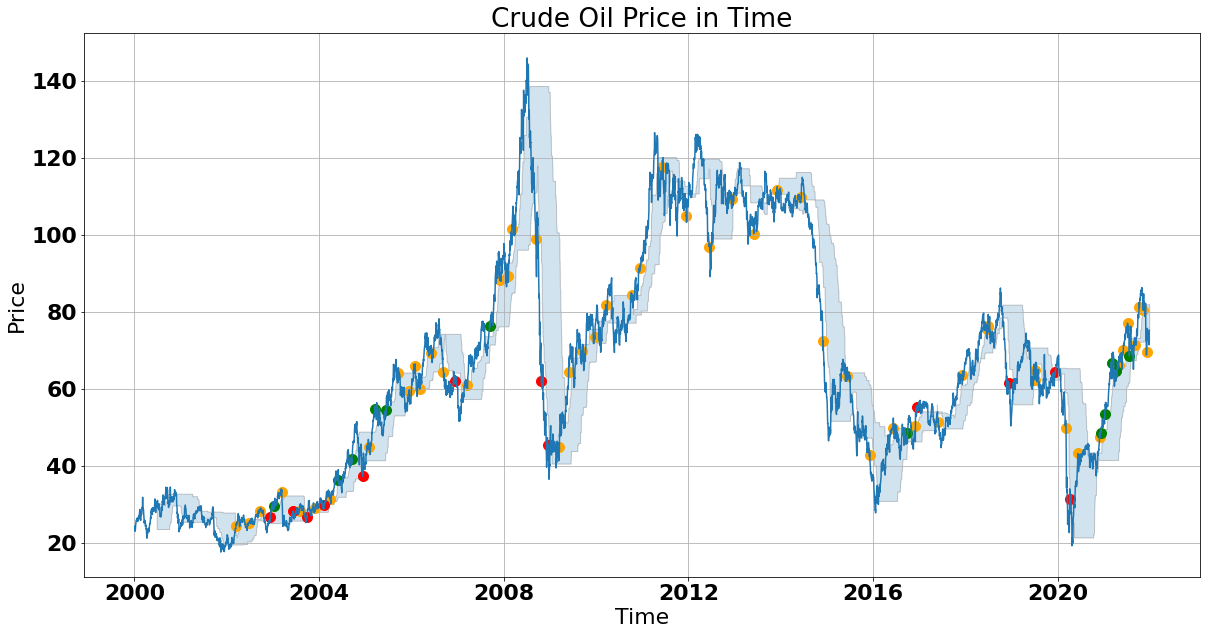

In [15]:
plt.plot(data.index, data['Index'])
plt.fill_between(data.index, data['min'], data['max'],alpha = 0.2,edgecolor = 'black')
plt.scatter(unchanged_dates, data.loc[unchanged_dates]['Index'], color = 'orange', s = 100)
plt.scatter(cut_dates, data.loc[cut_dates]['Index'], color = 'red',s = 100)
plt.scatter(increase_dates, data.loc[increase_dates]['Index'], color = 'green',s = 100)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Crude Oil Price in Time')
plt.grid()
plt.show()

In [16]:
final_categories = {'A1': [],'A2': [],'A3': [],'B1': [],'B2': [],'B3': [],'C1': [],'C2': [],'C3': []}

def get_final_categories():
    for index in cut_dates:
        if opec_meetings.loc[index]['mean'] > data.loc[index]['max']:
            final_categories['A1'].append(index)
        elif opec_meetings.loc[index]['mean'] < data.loc[index]['min']:
            final_categories['A2'].append(index)
        else:
            final_categories['A3'].append(index)
    for index in increase_dates:
        if opec_meetings.loc[index]['mean'] > data.loc[index]['max']:
            final_categories['B1'].append(index)
        elif opec_meetings.loc[index]['mean'] < data.loc[index]['min']:
            final_categories['B2'].append(index)
        else:
            final_categories['B3'].append(index)
    for index in unchanged_dates:
        if opec_meetings.loc[index]['mean'] > data.loc[index]['max']:
            final_categories['C1'].append(index)
        elif opec_meetings.loc[index]['mean'] < data.loc[index]['min']:
            final_categories['C2'].append(index)
        else:
            final_categories['C3'].append(index)
get_final_categories()

In [17]:
for category in final_categories:
    print(category, len(final_categories[category]))

A1 1
A2 5
A3 6
B1 7
B2 1
B3 4
C1 21
C2 12
C3 21


In [18]:
# we should make a class for each category

def get_return_dataframe(category):
    category_df_AR = pd.DataFrame(index = np.arange(days_after_to_show_return + np.abs(days_before_to_show_return)))
    for index in final_categories[category]:
        change = opec_meetings.loc[index]['Production Change']
        returns = get_window(brent_price, index, days_before_to_show_return, days_after_to_show_return, 'return').rename(columns = {'return': f'{index}__{change}'})
        returns.reset_index(drop = True,  inplace = True)
#         returns[str(index)] += 1
        category_df_AR = pd.merge(category_df_AR , returns, left_index = True, right_index = True)
    category_df_CAR = category_df_AR.cumsum()
    category_df_CAR['mean_return'] = category_df_CAR.mean(axis=1)
    category_df_AR['mean_return'] = category_df_AR.mean(axis=1)
    return category_df_AR , category_df_CAR    

all_categories_dfs = {}
A1 , A1_ = get_return_dataframe('A1')
all_categories_dfs['A1'] = [A1, A1_]
A2, A2_ = get_return_dataframe('A2')  
all_categories_dfs['A2'] = [A2, A2_]
A3, A3_ = get_return_dataframe('A3') 
all_categories_dfs['A3'] = [A3, A3_]

B1, B1_ = get_return_dataframe('B1')    
all_categories_dfs['B1'] = [B1, B1_]

B2, B2_ = get_return_dataframe('B2')    
all_categories_dfs['B2'] = [B2, B2_]

B3, B3_ = get_return_dataframe('B3')  
all_categories_dfs['B3'] = [B3, B3_]

C1, C1_ = get_return_dataframe('C1') 
all_categories_dfs['C1'] = [C1, C1_]

C2, C2_ = get_return_dataframe('C2') 
all_categories_dfs['C2'] = [C2, C2_]

C3, C3_ = get_return_dataframe('C3') 
all_categories_dfs['C3'] = [C3, C3_]


In [19]:
def plot_returns_for_each_category():
    ####
    for category in all_categories_dfs:
        df = all_categories_dfs[category][1]
        data = []
        for column in df.columns:
            if column != 'mean_return':
                data.append(go.Scatter(
                    y=df[column],
                    x=df.index, yaxis = 'y1',
                    mode = 'lines', name = column, line_color="#0000ff"))
        data.append(go.Scatter(
            y=df['mean_return'],
            x=df.index, yaxis = 'y1',
            mode = 'lines', name = 'mean_return', line_color="#f0000f"))
        layout = go.Layout(title=category,
                           yaxis=dict(title='return'))
        fig = go.Figure(data=data, layout=layout)
        fig.write_html(f"{name_of_directory}/{category}.html")

plot_returns_for_each_category()

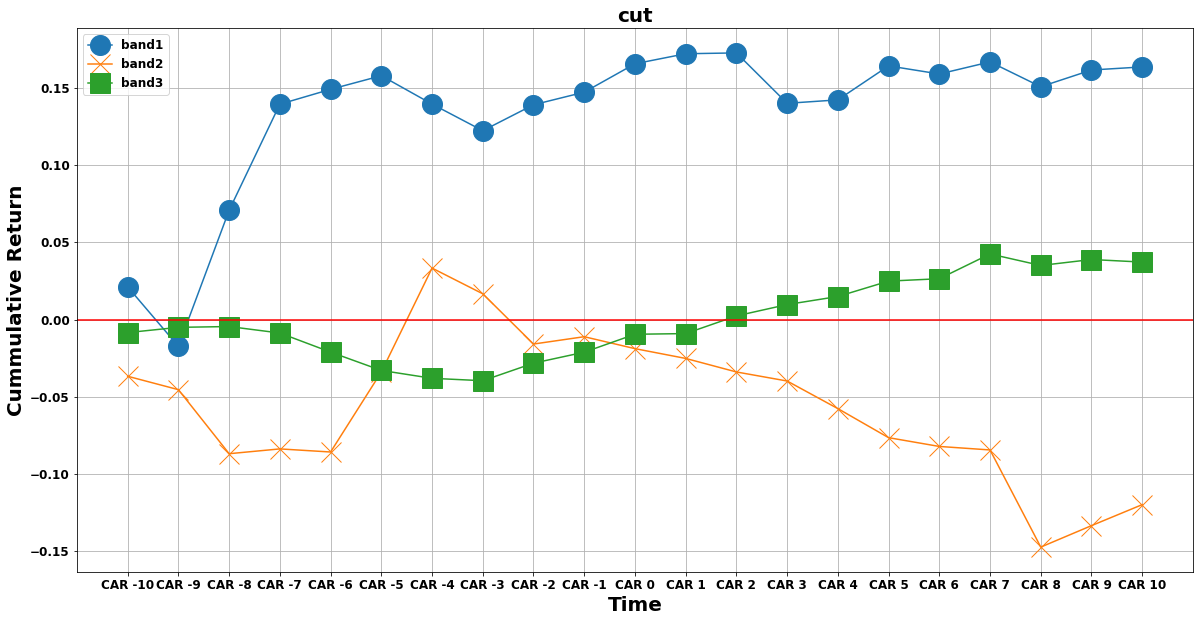

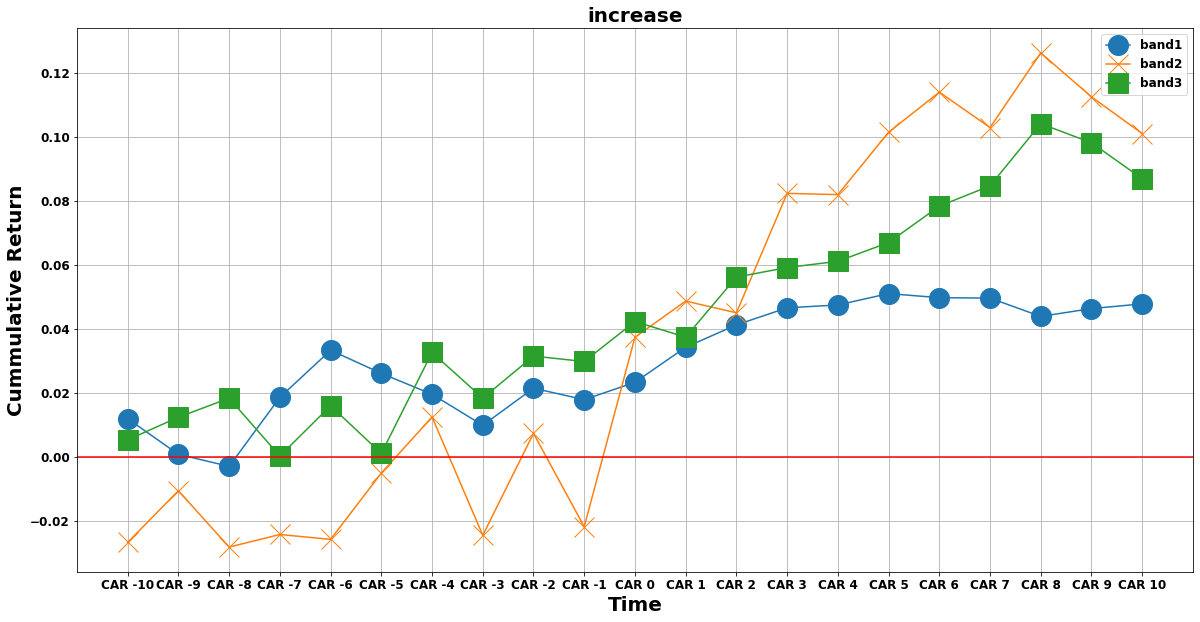

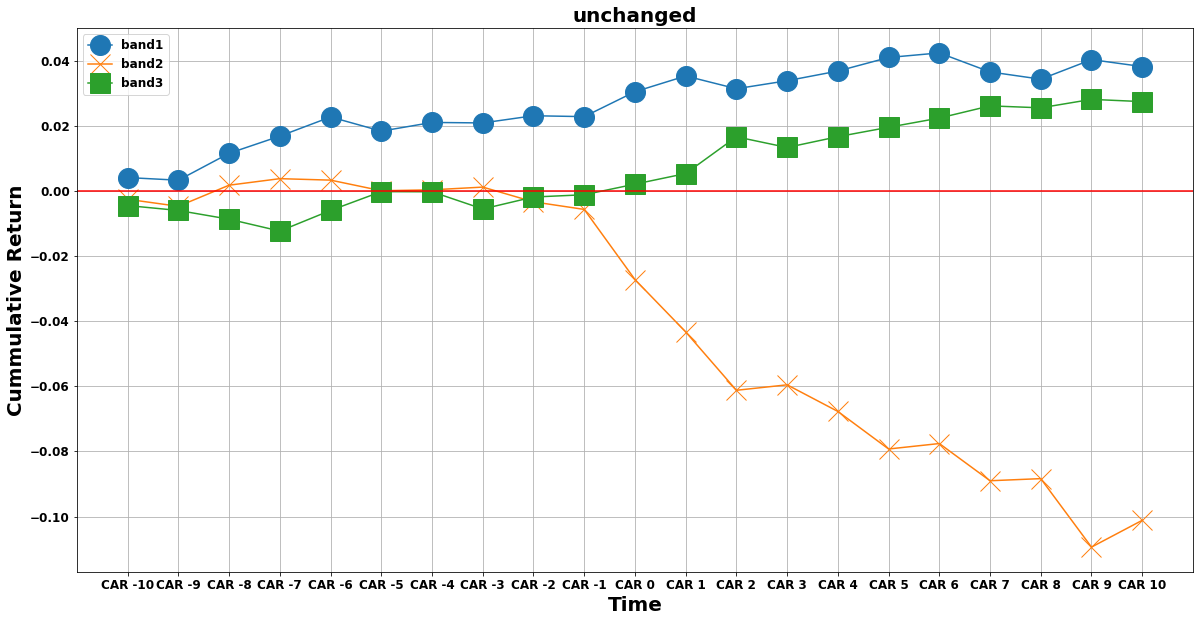

<Figure size 1440x720 with 0 Axes>

In [40]:
# for example all unchanged meetings in one plot
same_categories = {'cut':['A1','A2','A3'],'increase':['B1','B2','B3'],'unchanged':['C1','C2','C3']}
x_indexes = ['CAR -10','CAR -9','CAR -8','CAR -7','CAR -6','CAR -5','CAR -4','CAR -3','CAR -2',
             'CAR -1','CAR 0','CAR 1','CAR 2','CAR 3','CAR 4','CAR 5','CAR 6','CAR 7','CAR 8','CAR 9','CAR 10']
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

font_for_label = {'family':'normal', 'weight':'bold', 'size': 20}

matplotlib.rc('font', **font)
def plot_aggregate_plots_mean_return():
    for group_name in same_categories:
        x = same_categories[group_name]
        data = []
        for category in x:
            if '1' in category:
                category_name = 'high'
                legend_name = 'band1'
                marker = 'o'
            elif '2' in category:
                category_name = 'low'
                legend_name = 'band2'
                marker = 'x'
            else:
                category_name = 'normal'
                marker = 's'
                legend_name = 'band3'
            df = all_categories_dfs[category][1]
            plt.plot(x_indexes, df['mean_return'], label = legend_name, marker = marker, markersize = 20)
        plt.xlabel('Time',  fontdict=font_for_label)
        plt.ylabel('Cummulative Return',  fontdict=font_for_label)
        plt.title(group_name, fontdict = font_for_label)
        plt.legend()
        plt.grid()
        plt.axhline(y=0, color='r', linestyle='-')
        plt.show()
        plt.savefig(f'{name_of_directory}/{group_name}.png')
#         plt.savefig(f'{name_of_directory}/{group_name}.png')
        plt.clf()

plot_aggregate_plots_mean_return()

In [21]:
# for example all unchanged meetings in one plot
same_categories = [['A1','A2','A3'],['B1','B2','B3'],['C1','C2','C3']]
def plot_aggregate_plots():
    for x in same_categories:
        data = []
        for category in x:
            df = all_categories_dfs[category][1]
            for column in df.columns:
                if column != 'mean_return':
                    data.append(go.Scatter(
                        y=df[column],
                        x=df.index, yaxis = 'y1',
                        mode = 'lines', name = column,line=dict(
                        color=f'rgb({random.randint(1,255)}, {random.randint(1,255)}, {random.randint(1,255)})',
                        width=5)))
            layout = go.Layout(title=category,
                               yaxis=dict(title='return'))
        fig = go.Figure(data=data, layout=layout)
        fig.write_html(f"{name_of_directory}/{x[0]}_aggregated.html")

plot_aggregate_plots()
    

In [22]:
def plot_all_categories():
    data = []
    for category in all_categories_dfs:
        df = all_categories_dfs[category][1]
        data.append(go.Scatter(
            y=df['mean_return'],
            x=df.index, yaxis = 'y1',
            mode = 'lines', name = category))
    layout = go.Layout(title='all_categories',
                       yaxis=dict(title='return'))
    fig = go.Figure(data=data, layout=layout)
    fig.write_html(f"{name_of_directory}/all_categories.html")
plot_all_categories()

T-Test

In [38]:
def compute_correct_t_test(simple = True):
    if simple :
        i = 0
        tstat_name = 'AR'
    else:
        i = 1
        tstat_name = 'CAR'
    for category in all_categories_dfs:
        df = all_categories_dfs[category][i]
        df[f'{tstat_name}_tstat_final'] = np.nan
        meeting_dates = final_categories[category]
        sum_of_variances = 0
        N = 0
        for column_name in meeting_dates:
            date = column_name
#             date = datetime.datetime.strptime(column_date, '%Y-%m-%d %H:%M:%S')
            brent_estimation_variance = get_window(brent_price, date, window_start_date, window_end_date, 'return')['return'].var()
            sum_of_variances += brent_estimation_variance
            N += 1
        if N > 0:
            df['variance'] = np.nan
            df['variance'] = sum_of_variances / (N ** 2)
            if not simple :
                df['variance'] = df['variance'].cumsum()
            df['std'] = df['variance'] ** 0.5
            df[f'{tstat_name}_tstat'] = np.round(df['mean_return'] / df['std'],2)
#             print(df[f'{tstat_name}_tstat_final'][(1.64 <= df[f'{tstat_name}_tstat']) & (df[f'{tstat_name}_tstat'] <= 1.96)])
#             print(df[f'{tstat_name}_tstat'][1.64 <= df[f'{tstat_name}_tstat'] <= 1.96])
            df[f'{tstat_name}_tstat_final'][(1.64 <= np.abs(df[f'{tstat_name}_tstat'])) & (np.abs(df[f'{tstat_name}_tstat']) <= 1.96)] = df[f'{tstat_name}_tstat'][(1.64 <= np.abs(df[f'{tstat_name}_tstat'])) & (np.abs(df[f'{tstat_name}_tstat']) <= 1.96)].astype(str) + '*'
            df[f'{tstat_name}_tstat_final'][(1.96 < np.abs(df[f'{tstat_name}_tstat'])) & (np.abs(df[f'{tstat_name}_tstat'] < 2.57))] = df[f'{tstat_name}_tstat'][(1.96 < np.abs(df[f'{tstat_name}_tstat'])) & (np.abs(df[f'{tstat_name}_tstat']) < 2.57)].astype(str) + '**'
            df[f'{tstat_name}_tstat_final'][2.57 < np.abs(df[f'{tstat_name}_tstat'])] = df[f'{tstat_name}_tstat'][2.57 < np.abs(df[f'{tstat_name}_tstat'])].astype(str) + '***'
#             df[f'{tstat_name}_tstat'] = df[f'{tstat_name}_tstat'] + '%'
        
compute_correct_t_test(False)
compute_correct_t_test(True)

                

In [24]:
def find_column_from_string(df, name):
    for column in df.columns:
        if name in column:
            return column
        
def compute_new_t_test(simple= True):
    if simple :
        j = 0
        tstat_name = 'AR'
    else:
        j = 1
        tstat_name = 'CAR'
    for category in all_categories_dfs:
        df = all_categories_dfs[category][j]
        meeting_dates = final_categories[category]
        df['new_variance'] = 0
        df['new_std'] = np.nan
        i = 0
        N = 0
        if len(df.columns) > 0:
            column_name = df.columns[i]
            while True:
                if column_name == 'mean_return':
                    break
    #             print(column_name)
                df['new_variance'] += (df[column_name] - df['mean_return']) ** 2
                N += 1
                i += 1
                column_name = df.columns[i]
        if N > 0:
            df['new_variance'] /= (N - 1) 
            df['new_std'] = df['new_variance'] ** (0.5)
            df[f'new_{tstat_name}_t_test'] = df['mean_return'] / df['new_std']
compute_new_t_test(False)
compute_new_t_test(True)


In [39]:
with pd.ExcelWriter(f'{name_of_directory}/returns.xlsx') as writer:
    for category in all_categories_dfs:
        all_categories_dfs[category][0].to_excel(writer, sheet_name=f'{category}_simple')
        all_categories_dfs[category][1].to_excel(writer, sheet_name=f'{category}_cummulative')

In [ ]:
!zip -r f'name_of_directory'.zip name_of_directory